In [93]:
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import glob
from tqdm import tqdm
from scipy.ndimage import zoom
from tensorflow.keras import layers, Model

In [16]:
files = glob.glob("../../Data/TempRemoved/*.nii.gz")

images = []

for file in tqdm(files):
    img = nib.load(file).get_fdata() * 0.001
    images.append(img)

100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


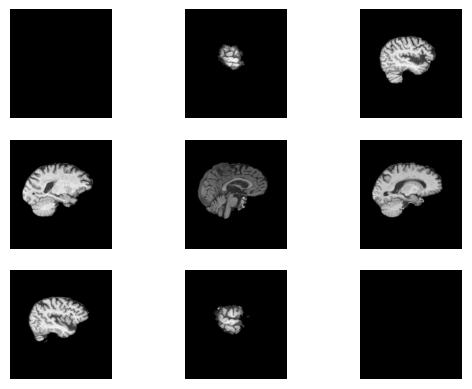

In [88]:
def imdisp(im, slice_axis=0):
    # Display 9 slices
    for i in range(9):
        plt.subplot(3, 3, i+1)
        slice_im = None
        j = int((i+1)*im.shape[slice_axis]/10)
        if slice_axis == 0: slice_im = im[j, :, :]
        if slice_axis == 1: slice_im = im[:, j, :]
        if slice_axis == 2: slice_im = im[:, :, j]
        plt.imshow(np.rot90(slice_im), cmap='gray')
        plt.axis('off')
    #plt.subplots_adjust(wspace=-0.55, hspace=0.04)
imdisp(images[0])

100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


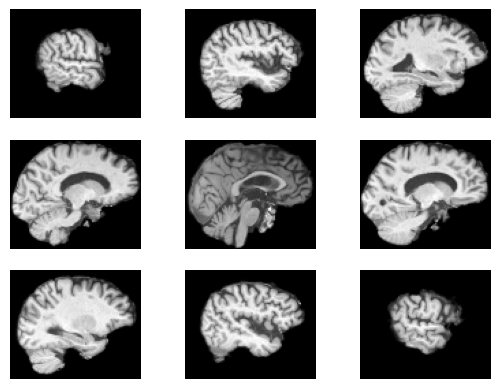

In [111]:
# Crop the image to only contain the brain
def crop_brain(img, target_size=(140,172,136)):
    brain_mask = img > 0.01
    # Find bounds in all axes
    bounds = np.where(brain_mask)
    x_min, x_max, y_min, y_max, z_min, z_max = np.min(bounds[0]), np.max(bounds[0]), np.min(bounds[1]), np.max(bounds[1]), np.min(bounds[2]), np.max(bounds[2])
    brain_img = img[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

    # Resize to target dimensions
    zoom_factors = [t / b for t, b in zip(target_size, brain_img.shape)]
    brain_img = zoom(brain_img, zoom_factors, order=1)  # Linear interpolation
    
    return brain_img

target_size = (80,96,80)
cropped_images = [crop_brain(img, target_size=target_size) for img in tqdm(images)]

imdisp(cropped_images[0])

# Model the brain with an Auto-Encoder

In [134]:
class AutoEncoder3D:
    def __init__(self, input_shape):
        # Encoder
        encoder_input = layers.Input(shape=input_shape)
        x = layers.Conv3D(4, (3, 3, 3), activation="relu", padding="same")(encoder_input)
        x = layers.MaxPooling3D((2, 2, 2), padding="same")(x)  # Single downscale block
        x = layers.Dropout(0.1)(x)
        encoded = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(x)  # Latent space

        self.encoder = Model(encoder_input, encoded, name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=encoded.shape[1:])  # Adjusted latent space shape
        x = layers.Conv3D(8, (3, 3, 3), activation="relu", padding="same")(decoder_input)
        x = layers.UpSampling3D((2, 2, 2))(x)  # Single upscale block
        decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)  # Final output layer

        self.decoder = Model(decoder_input, decoded, name="decoder")

        # Full Autoencoder (combine encoder and decoder)
        autoencoder_input = encoder_input
        autoencoder_output = self.decoder(self.encoder(encoder_input))
        self.autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

        # Compile the autoencoder
        self.autoencoder.compile(loss='mean_squared_error', optimizer='adam')
        self.autoencoder.summary()

    def train(self, x_train, epochs=2, batch_size=16):
        history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2
        )
        return history

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)


In [135]:
ae = AutoEncoder3D(list(target_size) + [1])
cropped_images = np.stack(cropped_images)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 80, 96, 80, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 40, 48, 40, 8)  │           984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 80, 96, 80, 1)  │         1,953 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,937 (11.47 KB)

 Trainable params: 2,937 (11.47 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
ae.train(cropped_images, epochs=160)

Epoch 1/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 2/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/160
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step - loss: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


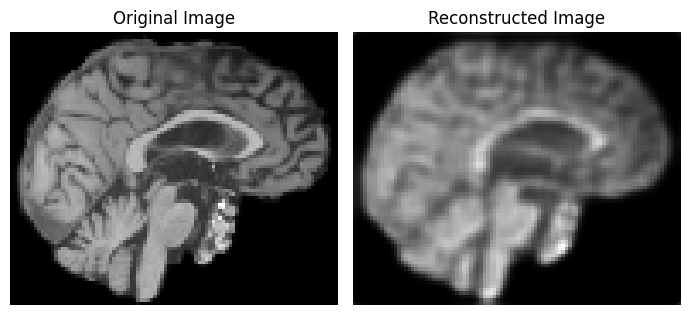

In [159]:
def reconstruct_and_plot(im):
    # Encode the image and reconstruct
    latent = ae.encode(im[np.newaxis, ...])  # Add batch dimension
    recon = ae.decode(latent)[0]  # Remove batch dimension after decoding

    # Set up the plot
    fig, ax = plt.subplots(1, 2, figsize=(7, 4), sharey=True)
    j = im.shape[0] // 2  # Middle slice along depth

    # Plot original image slice
    ax[0].imshow(np.rot90(im[j]), cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Plot reconstructed image slice
    ax[1].imshow(np.rot90(recon[j]), cmap='gray')
    ax[1].set_title("Reconstructed Image")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()
    return recon

recon = reconstruct_and_plot(cropped_images[0])

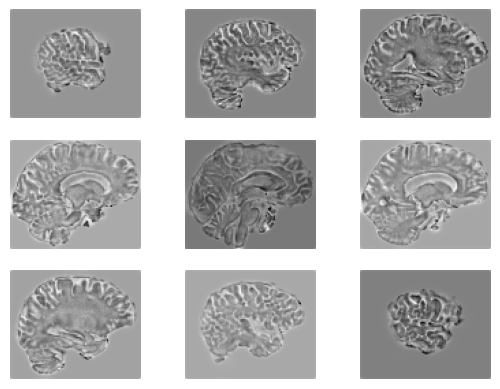

In [158]:
imdisp(recon.reshape(80,96,80) - cropped_images[0])